# Análise Dados - Concerta 2ª Formação

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
import matplotlib.colors as mcolors
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.patches as patches
os.environ["LOKY_MAX_CPU_COUNT"] = "4" # Evitar erro de memória no KMeans


## Ler o Dataframe

In [ ]:
data = pd.read_csv('online_new.csv')
data['datetime'] = pd.to_datetime(data['datetime'], format='mixed')
print(data.shape)

### MUDAR ###
data['time_hour'] = data['datetime'].dt.strftime('%H:%M')

(41011, 54)


## Distribuição do 'Engagement'

   person  average_engagement
0       0           78.320377
1       1           81.864635
2       2           69.331973
3       3           73.333909


C:\Users\danie\AppData\Local\Temp\ipykernel_16724\1845469974.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='person', y='average_engagement', data=engagement_mean_per_person, palette="viridis")


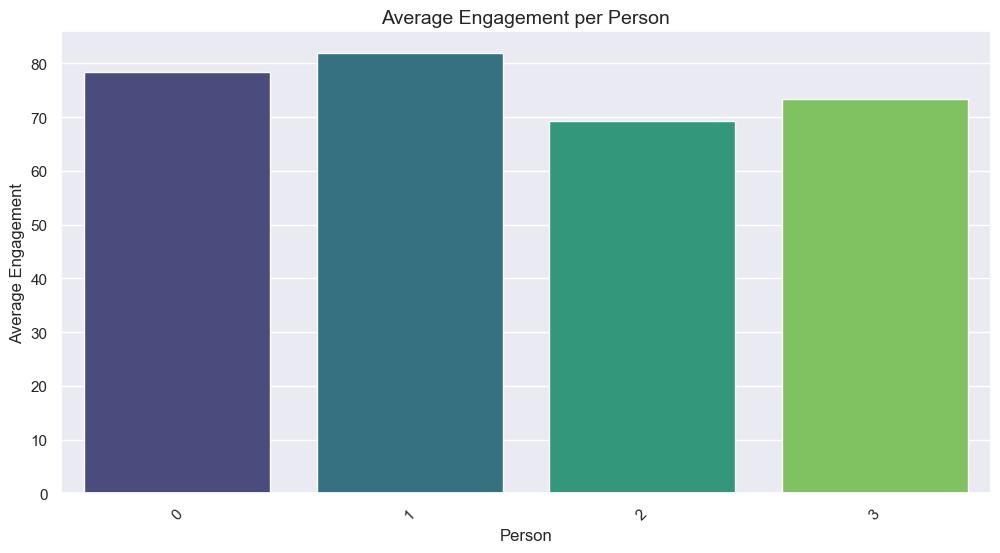

{0: 78.32037745991961, 1: 81.8646352784952, 2: 69.33197324367741, 3: 73.3339093978873}


In [98]:
engagement_mean_per_person = data.groupby('person')['engaged'].mean().reset_index()

engagement_mean_per_person.columns = ['person', 'average_engagement']
engagement_mean_per_person['average_engagement'] = engagement_mean_per_person['average_engagement'] * 100

print(engagement_mean_per_person.head())

plt.figure(figsize=(12, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x='person', y='average_engagement', data=engagement_mean_per_person, palette="viridis")
plt.title('Average Engagement per Person', fontsize=14)
plt.ylabel('Average Engagement', fontsize=12)
plt.xlabel('Person', fontsize=12)
plt.xticks(rotation=45)
plt.show()


engagement_mean = engagement_mean_per_person.set_index('person')['average_engagement'].to_dict()
print(engagement_mean)

## Distribuição das Expressões Faciais

admired: 4707 (11.48%)
tired: 2298 (5.6%)
neutral: 29549 (72.05%)
smilling: 4128 (10.07%)
frowning: 329 (0.8%)


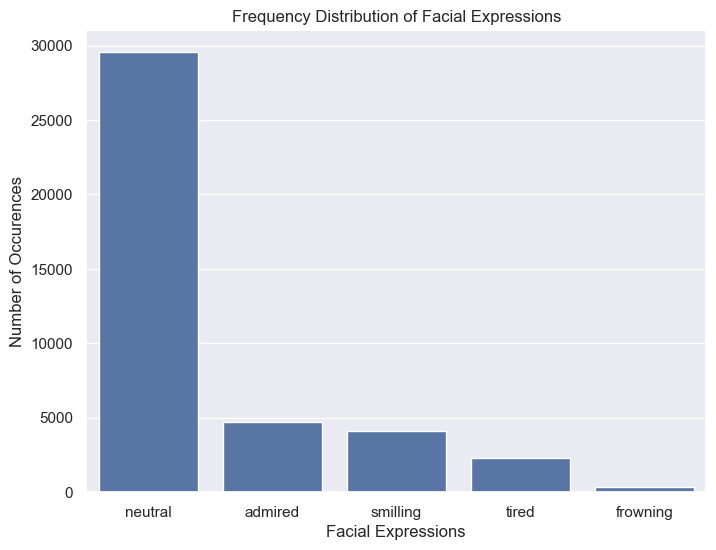

In [99]:
# Distribuição das emoções
emotions_count = data['facial_expression'].value_counts()
emotions = list(data['facial_expression'].unique())

# Plot da distribuição das emoções
for emotion in emotions:
    print(emotion + ": " + str(emotions_count.loc[emotion]) + " (" + str(round((emotions_count.loc[emotion] / data.shape[0]) * 100, 2)) + "%)")

plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.barplot(x=emotions_count.index, y=emotions_count.values)
plt.title('Frequency Distribution of Facial Expressions')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Facial Expressions', fontsize=12)
plt.show()

## Diferentes Emoções a cada 5 minutos enquanto Engaged

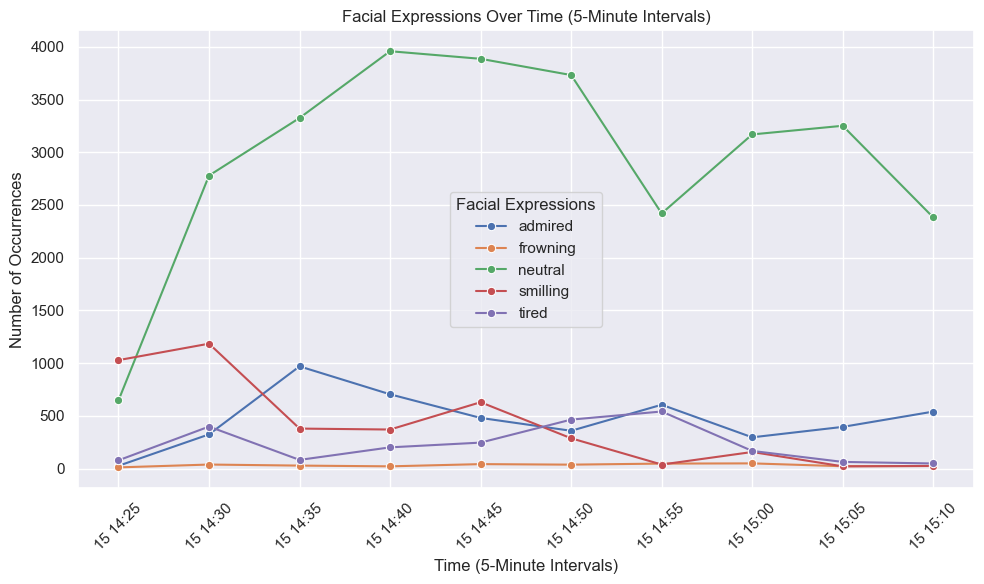

In [100]:
# # Numero de ocorrências de emoções a cada 5 minutos
data['5min'] = data['datetime'].dt.floor('5min')

# Agrupar por intervalo de tempo de 5 minutos e emoção
emotions_count_5min = data.groupby([data['5min'], data['facial_expression']]).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
sns.lineplot(data=emotions_count_5min, x='5min', y='counts', hue='facial_expression', marker="o")
plt.title('Facial Expressions Over Time (5-Minute Intervals)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Facial Expressions')
plt.tight_layout()
plt.show()


# # Numero de ocorrências de emoções a cada 5 minutos
# data_Engaged['5min'] = data_Engaged['datetime'].dt.floor('5min')

# # Agrupar por intervalo de tempo de 5 minutos e emoção
# emotions_count_5min = data_Engaged.groupby([data_Engaged['5min'], data_Engaged['emotion']]).size().reset_index(name='counts')
# total_counts_5min = emotions_count_5min.groupby('5min')['counts'].transform('sum')
# emotions_count_5min['percentage'] = (emotions_count_5min['counts'] / total_counts_5min) * 100


# plt.figure(figsize=(10, 6))
# sns.lineplot(data=emotions_count_5min, x='5min', y='percentage', hue='emotion', marker="o")
# plt.title('Facial Expressions Over Time (5-Minute Intervals) as Percentage')
# plt.ylabel('Percentage of Occurrences', fontsize=12)
# plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
# plt.xticks(rotation=45)
# plt.legend(title='Facial Expressions')
# plt.tight_layout()
# plt.show()

## Distribuição de Engaged a cada 5 minutos

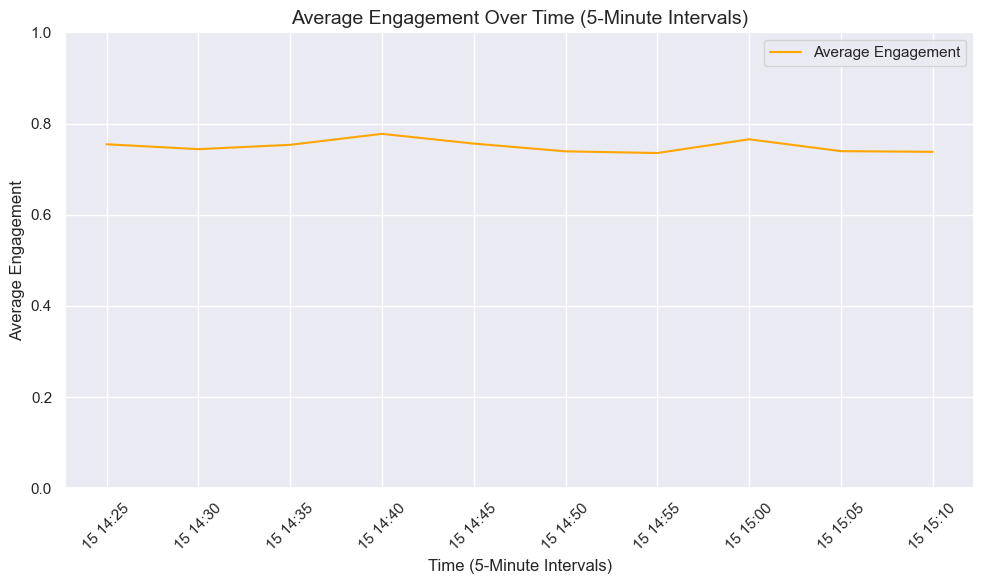

In [101]:
data['5min'] = data['datetime'].dt.floor('5min')
engaged_mean_5min = data.groupby('5min')['engaged'].mean().reset_index()

sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=engaged_mean_5min, x='5min', y='engaged', label='Average Engagement', color='orange')
plt.title('Average Engagement Over Time (5-Minute Intervals)', fontsize=14)
plt.ylabel('Average Engagement', fontsize=12)
plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title=None)
plt.tight_layout()
plt.show()


## Distribuição de Engagement de cada pessoa

C:\Users\danie\AppData\Local\Temp\ipykernel_16724\2537780887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='person', y='average_engagement', data=group_cluster_engagement, palette='viridis')


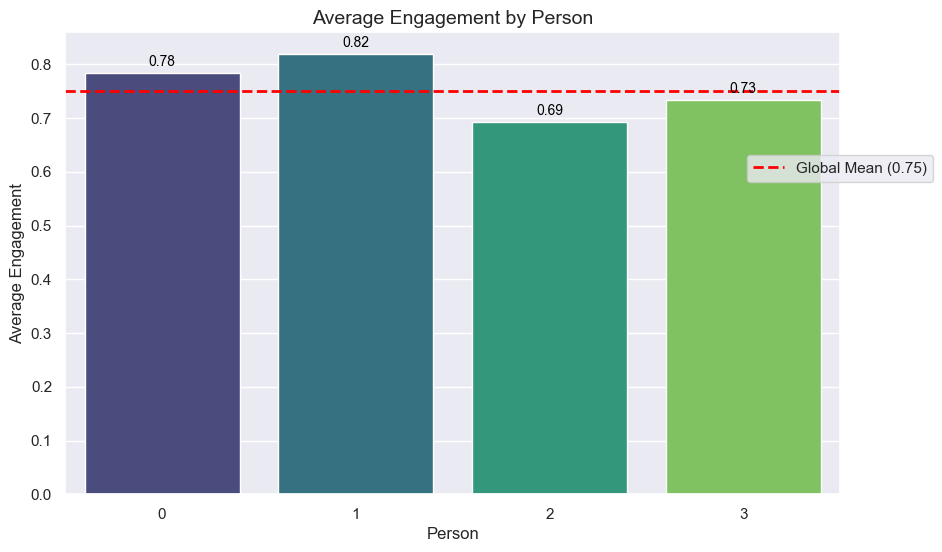

In [102]:
# Calcular a média de engagement por pessoa
group_cluster_engagement = data.groupby('person')['engaged'].mean().reset_index()

# Renomear colunas para clareza
group_cluster_engagement.columns = ['person', 'average_engagement']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='person', y='average_engagement', data=group_cluster_engagement, palette='viridis')

# Adicionar os valores da média em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='baseline', 
                    fontsize=10, color='black', 
                    xytext=(0, 5),  # Deslocamento em relação à barra
                    textcoords='offset points')

# Adicionar linha de referência para a média global
global_mean_engagement = data['engaged'].mean()  # Calcular média global automaticamente
plt.axhline(global_mean_engagement, color='red', linestyle='--', linewidth=2, label=f'Global Mean ({global_mean_engagement:.2f})')

# Configurar os títulos e rótulos
plt.title('Average Engagement by Person', fontsize=14)
plt.xlabel('Person', fontsize=12)
plt.ylabel('Average Engagement', fontsize=12)
plt.legend(title=None, bbox_to_anchor=(0.87, 0.75))

# Mostrar o gráfico
plt.show()


## Distribuição de Emotions de cada pessoa

In [103]:
# Agrupar por cluster e emoção, contando as ocorrências
group_cluster_emotion = data.groupby(['person', 'facial_expression']).size().reset_index(name='contagem')

# Calcular a percentagem de cada emoção dentro de cada cluster
group_cluster_emotion['percentagem'] = group_cluster_emotion.groupby('person')['contagem'].transform(lambda x: x / x.sum() * 100)


# Criar uma tabela pivot, onde as linhas são clusters, colunas são emoções e os valores são percentagens
tabela_emocoes = group_cluster_emotion.pivot(index='person', columns='facial_expression', values='percentagem')
# Alterar o nome da coluna no índice da tabela pivot
tabela_emocoes.rename_axis("Facial Expression", axis=1, inplace=True)
tabela_emocoes.rename_axis("Person", axis=0, inplace=True)
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#A9A9A9", "#DCDCDC", "#B0C4DE", "#A9A0A9"])
table = tabela_emocoes.style.format("{:.2f}%") \
    .background_gradient(cmap=cmap_custom, axis=1) \
    .set_table_styles([{'selector': 'thead th', 
                        'props': [('background-color', '#4F4F4F'),  # Cinza escuro no cabeçalho
                                  ('color', 'white'),
                                  ('font-size', '12px')]}]) \
    .set_properties(**{'border': '1px solid black', 'color': 'black', 'font-size': '10pt'}) \
    .set_caption("Percentage Distribution of Facial Expressions by Person")

display(table)

Facial Expression,admired,frowning,neutral,smilling,tired
Person,,,,,
0,17.02%,0.24%,63.27%,14.64%,4.83%
1,10.52%,nan%,75.16%,7.51%,6.80%
2,1.35%,1.67%,85.61%,5.76%,5.61%
3,22.16%,1.03%,58.87%,11.87%,6.06%


In [104]:

# Dados fornecidos
dataA = {
    'Person': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Grade': [
        'Aprovada por ser MV', 4.2, 19.2, 7.6, 19.1, 11.7, 19, 10.6, 17.1, 4.3, 'Não fez exame'
    ],
    'Education': [
        'DVM', '9 ano', 'Licenciado', '9 ano', 'Licenciado', '?', 'Mestrado', '9 ano', 'Mestrado', '9 ano', ''
    ],
    'Job': [
        'Não faz exame', 'Funcionário', 'Holandês - Dono de Expl.', 'Brasileiro - Funcionário',
        'Funcionário - Alto Cargo', 'Indiano Funcionário', 'Eng. Zootécnica', 'Funcionário', 'Eng. Agrónomo',
        'Funcionário', ''
    ]
}

# Criar DataFrame
df = pd.DataFrame(dataA)
df['Grade'] = df['Grade'].astype(str)

# Exibir tabela
styled_table = df.style.set_properties(
    **{
        'border': '1px solid gray',
        'color': 'gray',
        'font-size': '14pt'
        ''
    }
).set_caption("Tabela de Alunos com Notas e Grau Académico")

# Mostrar a tabela formatada
display(styled_table)


,Person,Grade,Education,Job
0,1,Aprovada por ser MV,DVM,Não faz exame
1,2,4.2,9 ano,Funcionário
2,3,19.2,Licenciado,Holandês - Dono de Expl.
3,4,7.6,9 ano,Brasileiro - Funcionário
4,5,19.1,Licenciado,Funcionário - Alto Cargo
5,6,11.7,?,Indiano Funcionário
6,7,19,Mestrado,Eng. Zootécnica
7,8,10.6,9 ano,Funcionário
8,9,17.1,Mestrado,Eng. Agrónomo
9,10,4.3,9 ano,Funcionário


In [105]:
# Inicializar dicionários para cada emoção
emotion_dicts = {emotion: {} for emotion in tabela_emocoes.columns}

# Preencher os dicionários com as percentagens em formato decimal
for emotion in tabela_emocoes.columns:
    for person, percentage in tabela_emocoes[emotion].items():
        # Dividir por 100 para converter em número entre 0 e 1
        emotion_dicts[emotion][person] = percentage / 100

# Exibir os dicionários para cada emoção
for emotion, emotion_dict in emotion_dicts.items():
    print(f"{emotion}_means: {emotion_dict}")
admired_means = emotion_dicts['admired']
tired_means = emotion_dicts['tired']
neutral_means = emotion_dicts['neutral']
smilling_means = emotion_dicts['smilling']
frowning_means = emotion_dicts['frowning']


admired_means: {0: 0.17016939621845786, 1: 0.10523952095808382, 2: 0.013545816733067729, 3: 0.22162247975869184}
frowning_means: {0: 0.002389822169115063, 1: nan, 2: 0.01666063020644694, 3: 0.010319098269566597}
neutral_means: {0: 0.6327405637168764, 1: 0.7516467065868262, 2: 0.8560666425208258, 3: 0.588664867439276}
smilling_means: {0: 0.14641175230196107, 1: 0.0751497005988024, 2: 0.05758783049619702, 3: 0.11874900777901252}
tired_means: {0: 0.04828846559358965, 1: 0.06796407185628743, 2: 0.056139080043462505, 3: 0.06064454675345292}


## Expressões Faciais de cada pessoa

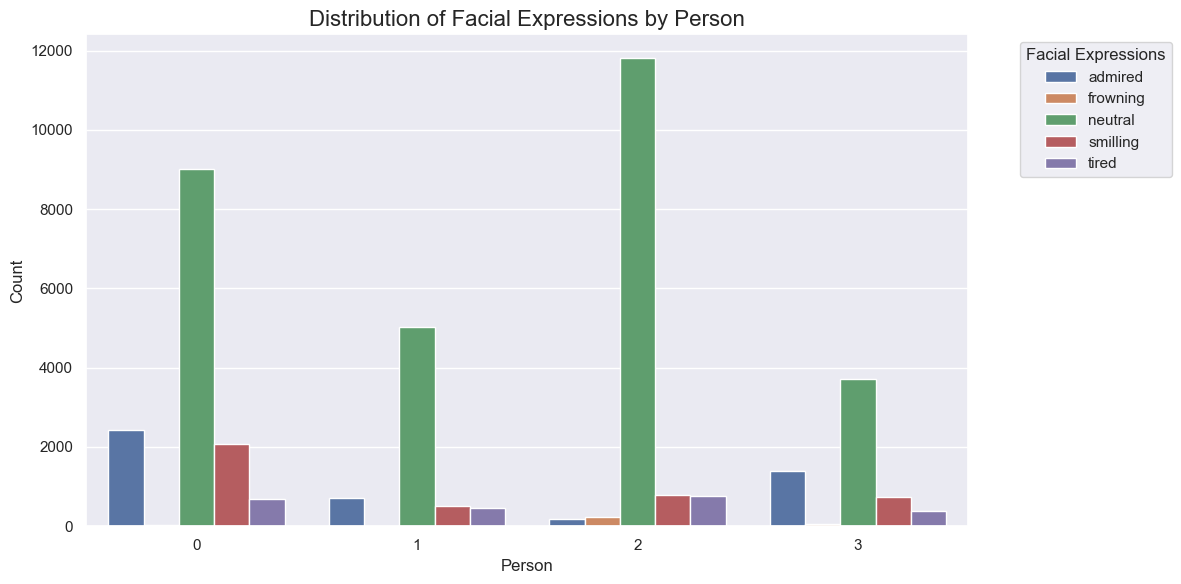

In [106]:

clusters = data['person'].unique()

# Configuração do Seaborn

# Preparar os dados para o gráfico
emotion_counts = data.groupby(['person', 'facial_expression']).size().reset_index(name='counts')

# Plotar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=emotion_counts, x='person', y='counts', hue='facial_expression', palette='deep')

# Personalizar o gráfico
plt.title('Distribution of Facial Expressions by Person', fontsize=16)
plt.xlabel('Person', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Facial Expressions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar o gráfico
plt.show()



## Facial Expressions de cada pessoa a cada 5 minutos

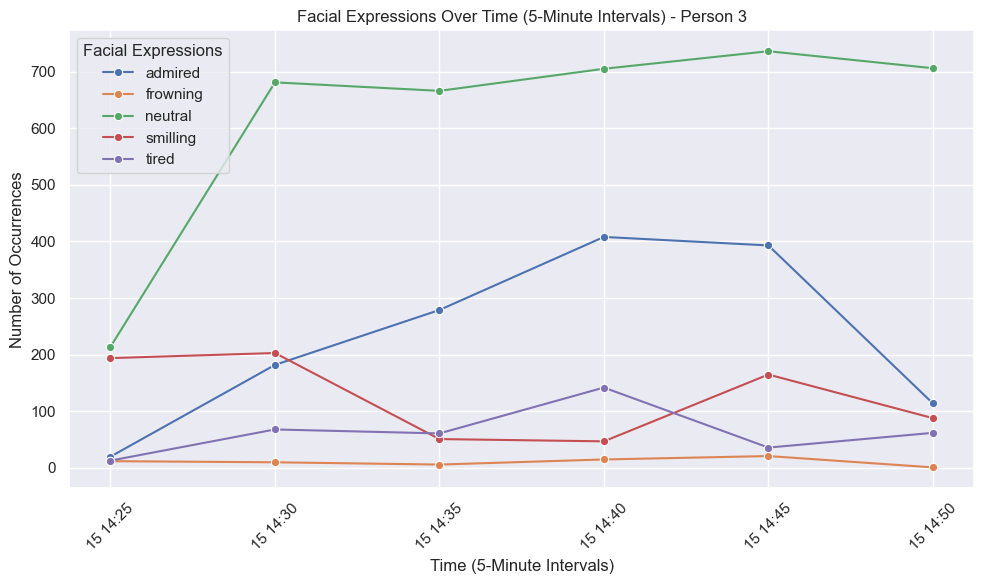

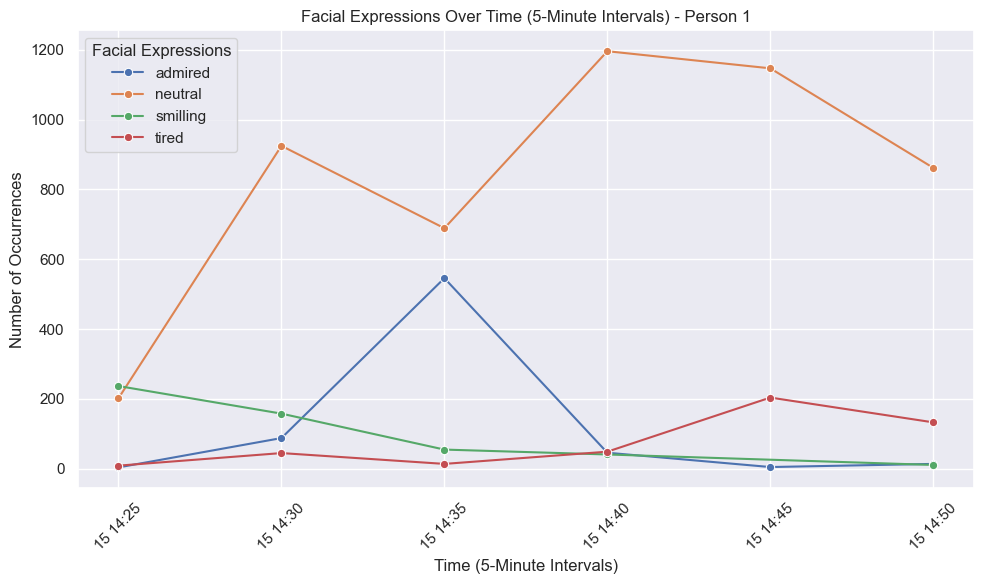

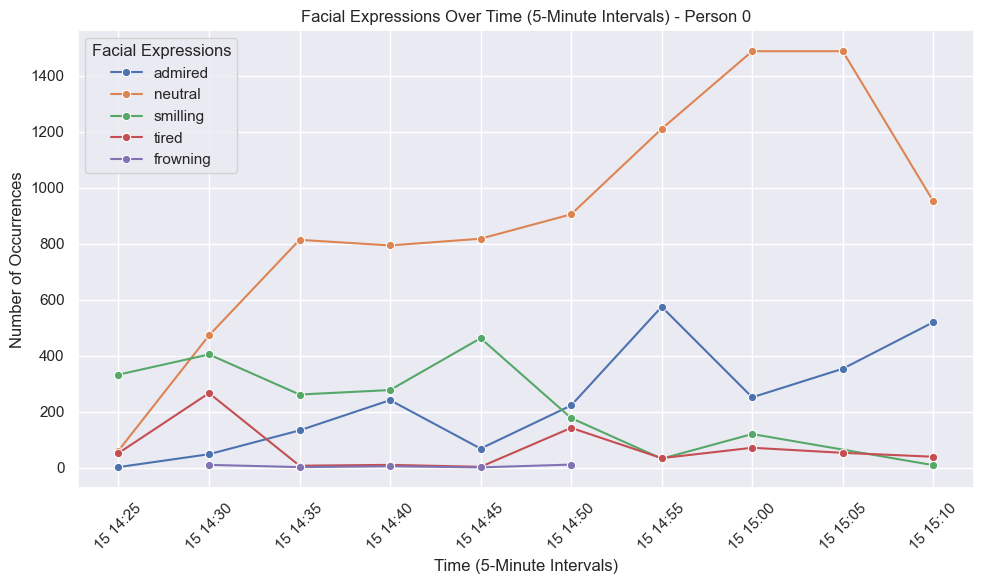

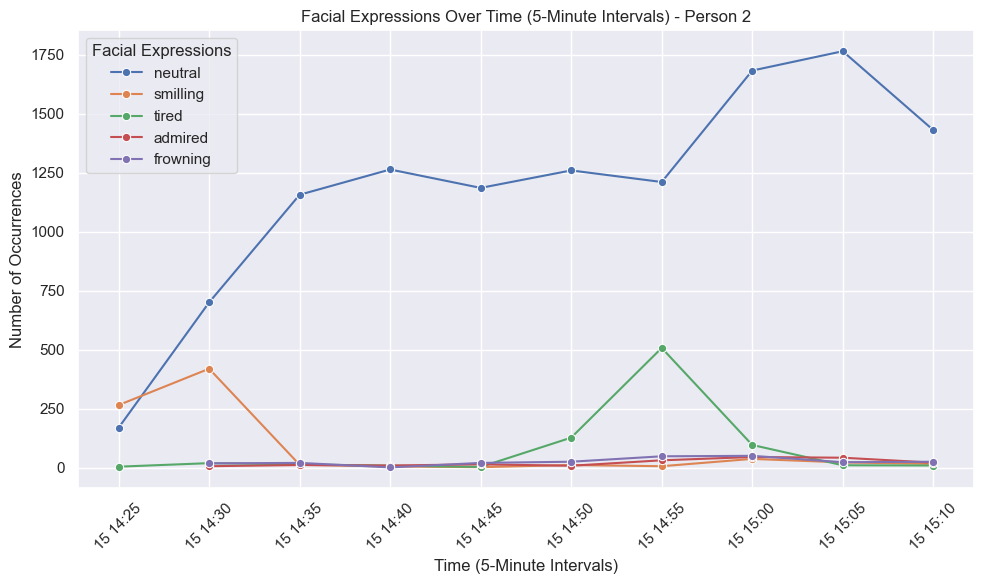

In [107]:
clusters = data['person'].unique()
for i in clusters:
    # Dataframe com dados do cluster especifico
    data_cluster_i = data[data['person'] == i]
    group_cluster_time =  data_cluster_i.groupby([data_cluster_i['5min'], data_cluster_i['facial_expression']]).size().reset_index(name='counts')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=group_cluster_time, x='5min', y='counts', hue='facial_expression', marker="o")
    plt.title(f'Facial Expressions Over Time (5-Minute Intervals) - Person {i}')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Time (5-Minute Intervals)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Facial Expressions')
    plt.tight_layout()
    plt.show()

## Variação do movimento da face

In [108]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'ad_displayed', 'head_yaw',
       'head_pitch', 'head_roll', 'left_eye_state', 'right_eye_state',
       'left_eye_state_confidence', 'right_eye_state_confidence', 'gaze_yaw',
       'gaze_pitch', 'pose_plus_gaze_yaw', 'pose_plus_gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'delta_distance_x',
       'delta_abs_distance_x', 'delta_distance_y', 'delta_abs_distance_y',
       'delta_distance_z', 'delta_abs_distance_z', 'distance_x_2min',
       'distance_y_2min', 'distance_z_2min', 'distance_x_60s',
       'distance_y_60s', 'distance_z_60s', 'diff_instant_head_yaw',
       'diff_instant_head_pitch', 'diff_instant_gaze_yaw',
       'diff_instant_gaze_pitch', 'gaze_yaw_abs', 'gaze_yaw_normalized',
       'gaze_pitch_abs', 'gaze_pitch_normalized', 'head_yaw_abs',
       'head_yaw_normalized', 'head_r

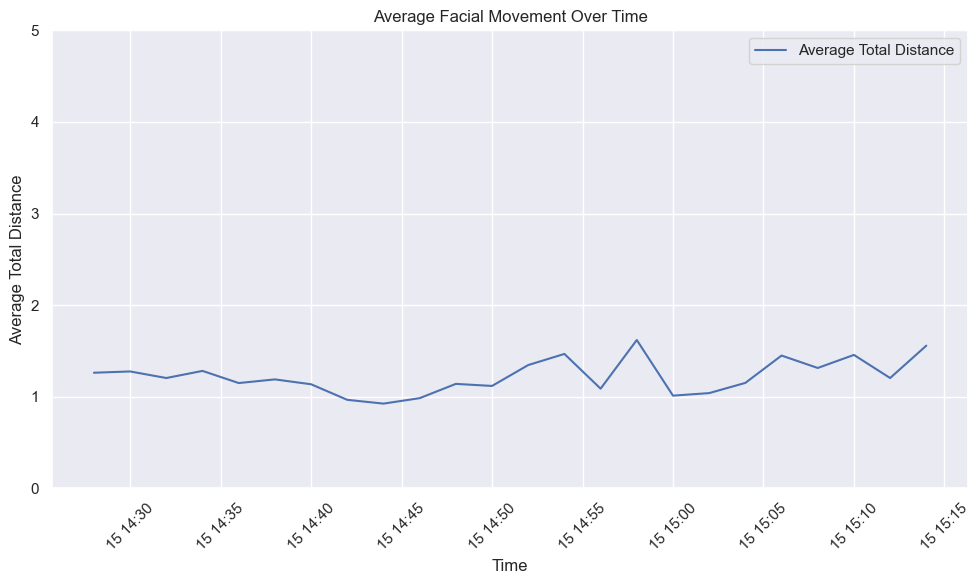

In [109]:
time_intervals = ['2min']
clusters = data['person'].unique()

# Inicializar um DataFrame para armazenar as médias
average_distance_per_interval = pd.DataFrame()

for time_interval in time_intervals:
    # Criar uma lista para armazenar os dataframes de cada pessoa
    person_distances = []
    
    for i in clusters:
        # Filtrar dados para o cluster atual
        data_cluster_i = data[data['person'] == i][['datetime', f'distance_x_{time_interval}', f'distance_y_{time_interval}']]
        
        # Calcular a distância total para cada pessoa
        data_cluster_i['distance_total'] = data_cluster_i[f'distance_x_{time_interval}'] + data_cluster_i[f'distance_y_{time_interval}']
        
        # Agrupar por intervalo de tempo e obter apenas o primeiro registro em cada grupo
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).first().reset_index()
        
        # Adicionar o dataframe da pessoa à lista
        person_distances.append(data_cluster_group[['datetime', 'distance_total']])
    
    # Concatenar todas as pessoas em um único DataFrame
    all_people_data = pd.concat(person_distances)
    
    # Agrupar novamente por datetime e calcular a média da distância total
    average_distance = all_people_data.groupby('datetime')['distance_total'].mean().reset_index()
    
    # Adicionar ao DataFrame de médias para comparação futura
    average_distance_per_interval = pd.concat([average_distance_per_interval, average_distance], ignore_index=True)


    # Plotar o gráfico da média da distância total ao longo do tempo
    plt.figure(figsize=(10, 6))
    plt.plot(average_distance['datetime'], average_distance['distance_total'], color='b', label='Average Total Distance')
    
    # Definir título e rótulos dos eixos
    plt.title(f'Average Facial Movement Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Total Distance')
    plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(0,5)
    
    # Ajuste de layout
    plt.tight_layout()
    plt.show()
    
    
    


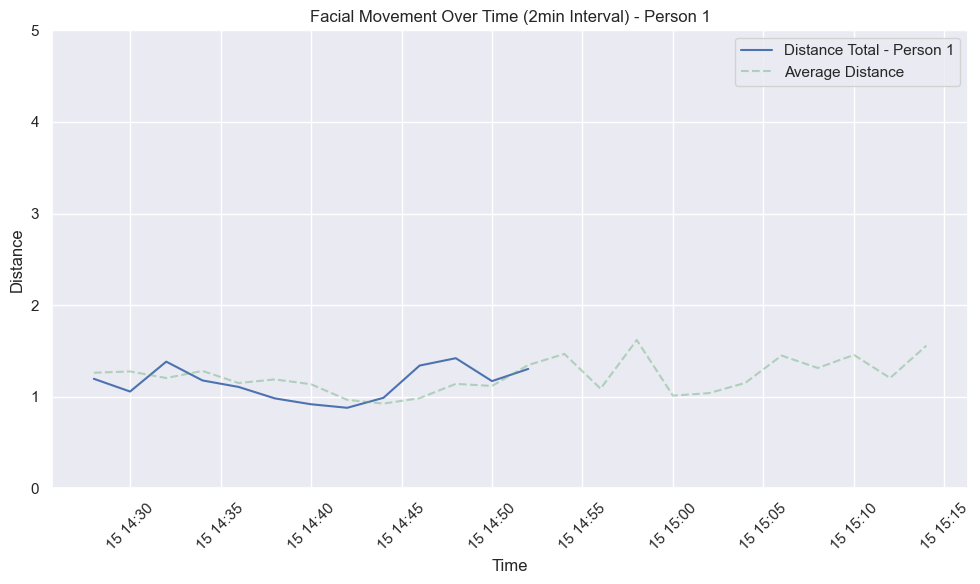

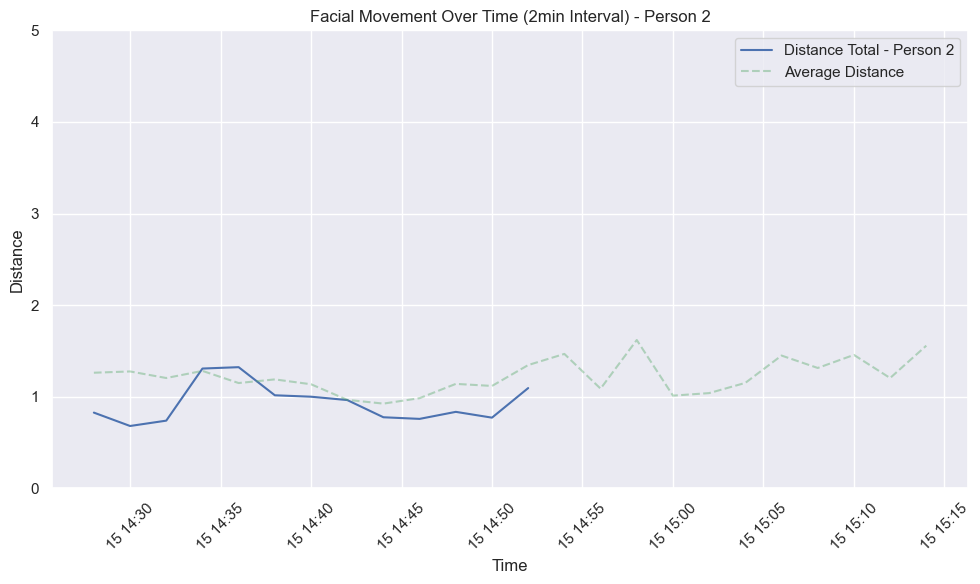

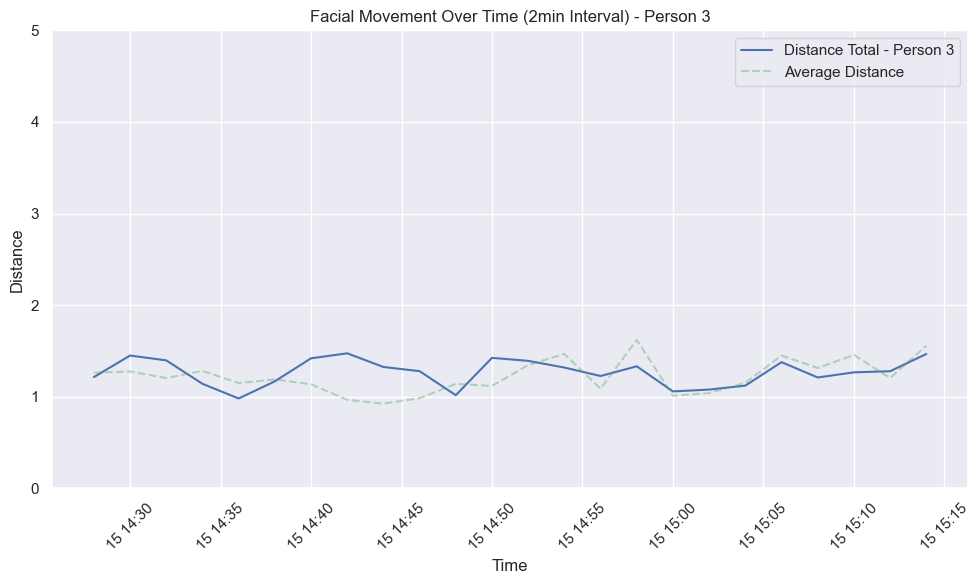

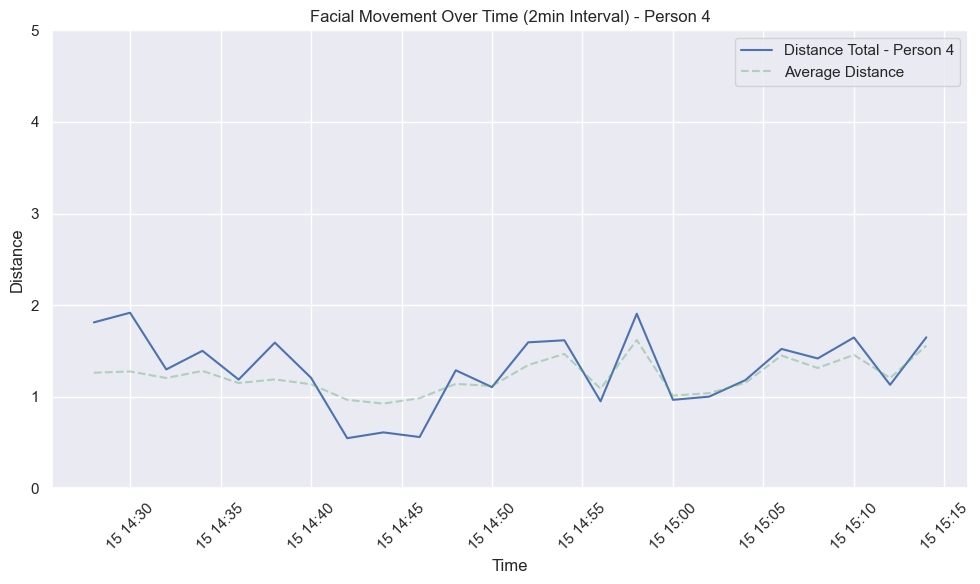

Face Variation Means: {np.int64(3): np.float64(1.1475548499028008), np.int64(1): np.float64(0.9298091715488037), np.int64(0): np.float64(1.267044148113109), np.int64(2): np.float64(1.2999890542497927)}


In [110]:
time_intervals = ['2min']
clusters = data['person'].unique()

# Inicializar um DataFrame para armazenar as médias
average_distance_per_interval = pd.DataFrame()

face_variation_means = {}

for time_interval in time_intervals:
    # Criar uma lista para armazenar os dataframes de cada pessoa
    person_distances = []
    
    for i in clusters:
        # Filtrar dados para o cluster atual
        data_cluster_i = data[data['person'] == i][['datetime', f'distance_x_{time_interval}', f'distance_y_{time_interval}']]
        
        # Calcular a distância total para cada pessoa
        data_cluster_i['distance_total'] = data_cluster_i[f'distance_x_{time_interval}'] + data_cluster_i[f'distance_y_{time_interval}']
        
        # Agrupar por intervalo de tempo e obter apenas o primeiro registro em cada grupo
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).first().reset_index()

        face_variation_means[i] = data_cluster_group['distance_total'].mean()
        
        # Adicionar o dataframe da pessoa à lista
        person_distances.append(data_cluster_group[['datetime', 'distance_total']])
    
    # Concatenar todas as pessoas em um único DataFrame
    all_people_data = pd.concat(person_distances)
    
    # Agrupar novamente por datetime e calcular a média da distância total
    average_distance = all_people_data.groupby('datetime')['distance_total'].mean().reset_index()

    # Plotar gráfico individual para cada pessoa, incluindo a linha média
    for i, data_cluster_group in enumerate(person_distances, start=1):
        plt.figure(figsize=(10, 6))

        # Plotar o distance_total da pessoa
        plt.plot(data_cluster_group['datetime'], data_cluster_group['distance_total'], color='b', label=f'Distance Total - Person {i}')
        
        # Adicionar a linha da média com transparência
        plt.plot(average_distance['datetime'], average_distance['distance_total'], color='g', alpha=0.4, linestyle='--', label='Average Distance')
        
        # Configurar o gráfico
        plt.title(f'Facial Movement Over Time ({time_interval} Interval) - Person {i}')
        plt.xlabel('Time')
        plt.ylabel('Distance')
        plt.ylim(0, 5)  # Definir a escala fixa do eixo y de 0 a 80
        plt.xticks(rotation=45)
        plt.legend()
        
        # Ajuste de layout
        plt.tight_layout()
        plt.show()

print("Face Variation Means:", face_variation_means)



In [111]:
time_intervals = ['2min']
clusters = data['person'].unique()
z_face_variation_means = {}

for time_interval in time_intervals:
    for i in clusters:
        
        data_cluster_i = data[data['person'] == i][['datetime', f'distance_z_{time_interval}']]
        
        # Agrupar por intervalo de tempo e calcular a média das mudanças na área (aproximações/afastamentos)
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).first().reset_index()

        z_face_variation_means[i] = data_cluster_group[f'distance_z_{time_interval}'].mean()
        
        #print(data_cluster_group)

        # plt.figure(figsize=(10, 5))
    
        # # Plotar a distância média (aproximação/afastamento)
        # plt.plot(data_cluster_group['datetime'], data_cluster_group[f'distance_z_{time_interval}'], label=f'Person {i}', color='red')
        # plt.axhline(0, color='black', linestyle='--', linewidth=2,alpha=0.3)

        # # # Destacar aproximações (quando a distância é positiva) e afastamentos (distância negativa)
        # # plt.fill_between(data_cluster_group['datetime'], data_cluster_group[f'distance_z_{time_interval}'], where=(data_cluster_group[f'distance_z_{time_interval}'] > 0), 
        # #              color='green', alpha=0.3, label='closeness')
        # # plt.fill_between(data_cluster_group['datetime'], data_cluster_group[f'distance_z_{time_interval}'], where=(data_cluster_group[f'distance_z_{time_interval}'] < 0), 
        # #              color='red', alpha=0.3, label='distance')

        # # Personalizar o gráfico
        # plt.title(f'Z Axis Variation Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # plt.ylabel('Distance Variation')
        # plt.xticks(rotation=45)
        # plt.ylim(-100,100)
        # plt.legend()
        # plt.grid(True)
        # plt.show()


print("Z Face Variation Means:", z_face_variation_means)
    


Z Face Variation Means: {np.int64(3): np.float64(0.5072343829455845), np.int64(1): np.float64(1.2040811925034591), np.int64(0): np.float64(-1.997242193814678), np.int64(2): np.float64(1.3468318131010575)}


## Head Position relativa por tempo

In [112]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'ad_displayed', 'head_yaw',
       'head_pitch', 'head_roll', 'left_eye_state', 'right_eye_state',
       'left_eye_state_confidence', 'right_eye_state_confidence', 'gaze_yaw',
       'gaze_pitch', 'pose_plus_gaze_yaw', 'pose_plus_gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'delta_distance_x',
       'delta_abs_distance_x', 'delta_distance_y', 'delta_abs_distance_y',
       'delta_distance_z', 'delta_abs_distance_z', 'distance_x_2min',
       'distance_y_2min', 'distance_z_2min', 'distance_x_60s',
       'distance_y_60s', 'distance_z_60s', 'diff_instant_head_yaw',
       'diff_instant_head_pitch', 'diff_instant_gaze_yaw',
       'diff_instant_gaze_pitch', 'gaze_yaw_abs', 'gaze_yaw_normalized',
       'gaze_pitch_abs', 'gaze_pitch_normalized', 'head_yaw_abs',
       'head_yaw_normalized', 'head_r

In [113]:
time_intervals = ['1min']
clusters = data['person'].unique()

yaw_head_relative_means = {}
pitch_head_relative_means = {}

yaw_gaze_relative_means = {}
pitch_gaze_relative_means = {}

for time_interval in time_intervals:
    for i in clusters:
        # Dataframe com dados do cluster específico
        data_cluster_i = data[data['person'] == i][['datetime', 'diff_instant_gaze_yaw', 'diff_instant_gaze_pitch', 'diff_instant_head_yaw','diff_instant_head_pitch']]
        
        # Agrupar por intervalos de tempo e calcular a média das colunas especificadas
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).mean().reset_index()

        yaw_head_relative_means[i] = data_cluster_group['diff_instant_head_yaw'].mean()
        pitch_head_relative_means[i] = data_cluster_group['diff_instant_head_pitch'].mean()

        yaw_gaze_relative_means[i] = data_cluster_group['diff_instant_gaze_yaw'].mean()
        pitch_gaze_relative_means[i] = data_cluster_group['diff_instant_gaze_pitch'].mean()
        
        data_cluster_group['time_hour'] = data_cluster_group['datetime'].dt.strftime('%H:%M')


        # Exibir o resultado para cada pessoa e intervalo de tempo
        print(f"Médias para a Pessoa {i} a cada {time_interval}:")
        # print(data_cluster_group)

        # # Criar o gráfico para 'diff_instant_gaze_yaw'
        # plt.figure(figsize=(12, 6))
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['diff_instant_gaze_yaw'], color='b', label='gaze yaw relative difference', alpha=0.8)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['diff_instant_head_yaw'], color='r', label='head yaw relative difference', alpha=0.5)
        # plt.title(f'Yaw Relative Difference To Others Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # plt.ylabel('Angle Difference')
        # tick_interval = 5  # Intervalo em número de pontos
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)  # Posições dos ticks
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]  # Rótulos correspondentes
        # plt.xticks(xticks_positions, xticks_labels, rotation=45)
        # plt.legend()
        # plt.ylim(0, 50)
        # plt.tight_layout()
        # plt.show()

        # # Criar o gráfico para 'diff_instant_gaze_pitch'
        # plt.figure(figsize=(12, 6))
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['diff_instant_gaze_pitch'], color='b', label='gaze pitch relative difference', alpha=0.8)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['diff_instant_head_pitch'], color='r', label='head pitch relative difference', alpha=0.5)
        # plt.title(f'Pitch Relative Difference To Others Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # plt.ylabel('Angle Difference')
        # tick_interval = 5  # Intervalo em número de pontos
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)  # Posições dos ticks
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]  # Rótulos correspondentes
        # plt.xticks(xticks_positions, xticks_labels, rotation=45)
        # plt.legend()
        # plt.ylim(0, 50)
        # plt.tight_layout()
        # plt.show()

print("Yaw Relative Means Head", yaw_head_relative_means)
print("Pitch Relative Means Head", pitch_head_relative_means)

print("Yaw Relative Means Gaze", yaw_gaze_relative_means)
print("Pitch Relative Means Gaze", pitch_gaze_relative_means)


Médias para a Pessoa 3 a cada 1min:
Médias para a Pessoa 1 a cada 1min:
Médias para a Pessoa 0 a cada 1min:
Médias para a Pessoa 2 a cada 1min:
Yaw Relative Means Head {np.int64(3): np.float64(21.824193955953685), np.int64(1): np.float64(9.553176974645684), np.int64(0): np.float64(21.802817531003974), np.int64(2): np.float64(32.61103729157924)}
Pitch Relative Means Head {np.int64(3): np.float64(11.860136561818933), np.int64(1): np.float64(12.927841977602238), np.int64(0): np.float64(15.879596039731428), np.int64(2): np.float64(15.314301687378165)}
Yaw Relative Means Gaze {np.int64(3): np.float64(25.035057957526604), np.int64(1): np.float64(12.991644483791914), np.int64(0): np.float64(25.188133983067697), np.int64(2): np.float64(34.40835878129856)}
Pitch Relative Means Gaze {np.int64(3): np.float64(7.177187001434289), np.int64(1): np.float64(7.696094933937214), np.int64(0): np.float64(9.15524075195936), np.int64(2): np.float64(9.46434324450008)}


In [114]:
data.columns

Index(['datetime', 'source', 'face', 'face_bbox_x1', 'face_bbox_y1',
       'face_bbox_x2', 'face_bbox_y2', 'ad_displayed', 'head_yaw',
       'head_pitch', 'head_roll', 'left_eye_state', 'right_eye_state',
       'left_eye_state_confidence', 'right_eye_state_confidence', 'gaze_yaw',
       'gaze_pitch', 'pose_plus_gaze_yaw', 'pose_plus_gaze_pitch',
       'facial_expression', 'race', 'gender', 'age', 'face_center_x',
       'face_center_y', 'face_area', 'person', 'delta_distance_x',
       'delta_abs_distance_x', 'delta_distance_y', 'delta_abs_distance_y',
       'delta_distance_z', 'delta_abs_distance_z', 'distance_x_2min',
       'distance_y_2min', 'distance_z_2min', 'distance_x_60s',
       'distance_y_60s', 'distance_z_60s', 'diff_instant_head_yaw',
       'diff_instant_head_pitch', 'diff_instant_gaze_yaw',
       'diff_instant_gaze_pitch', 'gaze_yaw_abs', 'gaze_yaw_normalized',
       'gaze_pitch_abs', 'gaze_pitch_normalized', 'head_yaw_abs',
       'head_yaw_normalized', 'head_r

In [115]:
time_intervals = ['1min']
clusters = data['person'].unique()

yaw_head_means = {}
pitch_head_means = {}

yaw_gaze_means = {}
pitch_gaze_means = {}

for time_interval in time_intervals:
    for i in clusters:
        data_cluster_i = data[data['person'] == i][['datetime', 'gaze_pitch', 'gaze_yaw', 'head_pitch', 'head_yaw']]
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).mean().reset_index().fillna(0)

        yaw_head_means[i] = data_cluster_group['head_yaw'].mean()
        pitch_head_means[i] = data_cluster_group['head_pitch'].mean()	

        yaw_gaze_means[i] = data_cluster_group['gaze_yaw'].mean()
        pitch_gaze_means[i] = data_cluster_group['gaze_pitch'].mean()
        


        data_cluster_group['time_hour'] = data_cluster_group['datetime'].dt.strftime('%H:%M')
    
        # plt.figure(figsize=(12, 6))
        # plt.axhline(0, color='black', linestyle='--', linewidth=2,alpha=0.3)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['gaze_pitch'], label='gaze pitch', color='blue', alpha=0.8)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['head_pitch'], label='head pitch', color='red', alpha=0.5)
    

        # plt.title(f'Pitch Variation Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # tick_interval = 5  # Intervalo em número de pontos
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)  # Posições dos ticks
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]  # Rótulos correspondentes
        # plt.xticks(xticks_positions, xticks_labels,rotation=45)
        # plt.ylabel('Angle Variation')
        # plt.ylim(-50,50)
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        
        
        
        # plt.figure(figsize=(12, 6))
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['gaze_yaw'], label='gaze yaw', color='blue', alpha=0.8)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['head_yaw'], label='head_yaw', color='red', alpha=0.5)

        # plt.title(f'Yaw Variation Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # plt.axhline(0, color='black', linestyle='--', linewidth=2,alpha=0.3)
        # tick_interval = 5  # Intervalo em número de pontos
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)  # Posições dos ticks
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]  # Rótulos correspondentes
        # plt.xticks(xticks_positions, xticks_labels,rotation=45)
        # plt.ylabel('Angle Variation')
        # plt.ylim(-50,50)
        # plt.legend()
        # plt.grid(True)
        # plt.show()

print("Yaw Head Means: ",  yaw_head_means)
print("Pitch Head Means: ", pitch_head_means)

print("Yaw Gaze Means: ", yaw_gaze_means)
print("Pitch Gaze Means: ", pitch_gaze_means)

Yaw Head Means:  {np.int64(3): np.float64(-15.048444611633393), np.int64(1): np.float64(0.2546950071311556), np.int64(0): np.float64(-3.9974527563786633), np.int64(2): np.float64(25.929366627466134)}
Pitch Head Means:  {np.int64(3): np.float64(7.663816349234181), np.int64(1): np.float64(10.474337233699186), np.int64(0): np.float64(6.94036841879994), np.int64(2): np.float64(0.6233722987791167)}
Yaw Gaze Means:  {np.int64(3): np.float64(-17.638534483385254), np.int64(1): np.float64(-1.4876235125723238), np.int64(0): np.float64(-6.07894470558843), np.int64(2): np.float64(24.80240858101694)}
Pitch Gaze Means:  {np.int64(3): np.float64(-6.196570366015347), np.int64(1): np.float64(-4.681048694497488), np.int64(0): np.float64(-0.7016670635130456), np.int64(2): np.float64(-3.4831498641737477)}


In [116]:
time_intervals = ['1min']
clusters = data['person'].unique()

yaw_difference_means = {}
pitch_difference_means = {}


for time_interval in time_intervals:
    for i in clusters:
        data_cluster_i = data[data['person'] == i][['datetime', 'gaze_pitch', 'gaze_yaw', 'head_pitch', 'head_yaw']]
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).mean().reset_index().fillna(0)
        data_cluster_group['abs_diff_pitch'] = abs(data_cluster_group['gaze_pitch'] - data_cluster_group['head_pitch'])
        data_cluster_group['abs_diff_yaw'] = abs(data_cluster_group['gaze_yaw'] - data_cluster_group['head_yaw'])

        yaw_difference_means[i] = data_cluster_group['abs_diff_yaw'].mean()
        pitch_difference_means[i] = data_cluster_group['abs_diff_pitch'].mean()


        data_cluster_group['time_hour'] = data_cluster_group['datetime'].dt.strftime('%H:%M')

        # Terceiro gráfico: Diferenças absolutas
        # plt.figure(figsize=(12, 6))
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['abs_diff_pitch'], label='pitch absolute difference', color='green', alpha=0.8)
        # plt.title(f'Pitch - Gaze and Head Difference Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]
        # plt.xticks(xticks_positions, xticks_labels, rotation=45)
        # plt.ylabel('Absolute Difference')
        # plt.ylim(0,50)
        # plt.legend()
        # plt.grid(True)
        # plt.show()

                # Terceiro gráfico: Diferenças absolutas
        # plt.figure(figsize=(12, 6))
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['abs_diff_yaw'], label='yaw absolute difference', color='purple', alpha=0.8)
        # plt.title(f'Yaw - Gaze and Head Difference Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]
        # plt.xticks(xticks_positions, xticks_labels, rotation=45)
        # plt.ylabel('Absolute Difference')
        # plt.ylim(0,50)
        # plt.legend()
        # plt.grid(True)
        # plt.show()

print("Yaw Difference Means: ", yaw_difference_means)
print("Pitch Difference Means: ", pitch_difference_means)

Yaw Difference Means:  {np.int64(3): np.float64(5.275824976867792), np.int64(1): np.float64(3.044986807115663), np.int64(0): np.float64(4.923184488250883), np.int64(2): np.float64(3.6265846142659073)}
Pitch Difference Means:  {np.int64(3): np.float64(13.974645270382606), np.int64(1): np.float64(15.155385928196678), np.int64(0): np.float64(10.089292451357931), np.int64(2): np.float64(5.016879444692748)}


### Roll Variation Head Position

In [117]:
time_intervals = ['1min']
clusters = data['person'].unique()
roll_head_means = {}

for time_interval in time_intervals:
    for i in clusters:
        data_cluster_i = data[data['person'] == i][['datetime', 'head_roll']]
        data_cluster_group = data_cluster_i.groupby(pd.Grouper(key='datetime', freq=time_interval)).mean().reset_index().fillna(0)
        roll_head_means[i] = data_cluster_group['head_roll'].mean()


        data_cluster_group['time_hour'] = data_cluster_group['datetime'].dt.strftime('%H:%M')
    
        # plt.figure(figsize=(12, 6))
        # plt.axhline(0, color='black', linestyle='--', linewidth=2,alpha=0.3)
        # plt.plot(data_cluster_group['time_hour'], data_cluster_group['head_roll'], label='head roll', color='green', alpha=0.5)
    

        # plt.title(f'Roll Variation Over Time ({time_interval} Interval) - Person {i}')
        # plt.xlabel('Time')
        # tick_interval = 5  # Intervalo em número de pontos
        # xticks_positions = range(2, len(data_cluster_group['time_hour']), tick_interval)  # Posições dos ticks
        # xticks_labels = data_cluster_group['time_hour'].iloc[xticks_positions]  # Rótulos correspondentes
        # plt.xticks(xticks_positions, xticks_labels,rotation=45)
        # plt.ylabel('Angle Variation')
        # plt.ylim(-50,50)
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        
        
print("Roll Head Means:", roll_head_means)

Roll Head Means: {np.int64(3): np.float64(-7.186370297908672), np.int64(1): np.float64(4.184272344333555), np.int64(0): np.float64(0.5861579833440158), np.int64(2): np.float64(1.4169257192858007)}
